In [24]:
import torch
import torchvision
import torch.nn as nn

import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Extract & Transform Data
download = True if os.path.exists('MNIST') else True
train_data = torchvision.datasets.MNIST(
                            root = '.',
                            train= True,
                            transform = torchvision.transforms.ToTensor(),
                            download = download
                                )

test_data = torchvision.datasets.MNIST(
                            root = '.',
                            train= False,
                            transform = torchvision.transforms.ToTensor(),
                            download = download
                                )

In [3]:
Ntrain, W, H = train_data.data.shape
Ntest = test_data.data.shape[0]

In [4]:
# Load Data
batch_size = 64

'''
Note than originally pixel intensities in the range of (0, 255). But when we load data using 
dataloader, it internally normalize data into (0,1) scale.

'''

train_loader = torch.utils.data.DataLoader(
                                        dataset=train_data,
                                        batch_size=batch_size,
                                        shuffle=True
                                        )

test_loader = torch.utils.data.DataLoader(
                                        dataset=test_data,
                                        batch_size=batch_size,
                                        shuffle=False
                                        )

In [5]:
# Device Selection
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
device

device(type='cpu')

In [8]:
# Model, Metrics & Paramaters

model = nn.Sequential(
                nn.Linear(W * H, 128),
                nn.ReLU(),
                nn.Linear(128, 10)
                )
model.to(device) # Transfer All the Paramaters of The Model to GPU

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [9]:
n_epoches = 10 

TrainLoss = []
TestLoss = []

for epoch in range(n_epoches):
    train_loss_epoch = []
    test_loss_epoch  = []
    for x, y in train_loader:
        # Since model moved into device, you should do your computaions on the selected device aswell.
        x = x.to(device) 
        y = y.to(device)
        
        x = x.view(-1, W * H)
        
        optimizer.zero_grad()

        prediction = model(x)
        loss = criterion(prediction, y)
        train_loss_epoch.append(loss.item())

        loss.backward()
        optimizer.step()
        
    train_loss_epoch = np.mean(train_loss_epoch)
    TrainLoss.append(train_loss_epoch)
    
    for x, y in test_loader:
        x = x.to(device) 
        y = y.to(device)
        
        x = x.view(-1, W * H)
    
        prediction = model(x)
        loss = criterion(prediction, y)
        test_loss_epoch.append(loss.item())
        
    test_loss_epoch = np.mean(test_loss_epoch)
    TestLoss.append(test_loss_epoch)
    
    print("epoch {}/{} , Train Loss : {} , Test Loss : {}".format(epoch+1, n_epoches, train_loss_epoch, test_loss_epoch))

epoch 1/10 , Train Loss : 0.3408547815785352 , Test Loss : 0.18463311840002988
epoch 2/10 , Train Loss : 0.1556284975018233 , Test Loss : 0.12565997548721683
epoch 3/10 , Train Loss : 0.10922413280527633 , Test Loss : 0.10033452168335415
epoch 4/10 , Train Loss : 0.08360126772935171 , Test Loss : 0.09178826939069909
epoch 5/10 , Train Loss : 0.06538520210476191 , Test Loss : 0.08775168452130121
epoch 6/10 , Train Loss : 0.0543324654690548 , Test Loss : 0.07999395934425911
epoch 7/10 , Train Loss : 0.04313131862643685 , Test Loss : 0.0760497905078172
epoch 8/10 , Train Loss : 0.03529423225481412 , Test Loss : 0.07872424697392964
epoch 9/10 , Train Loss : 0.030092230017881777 , Test Loss : 0.07353893739014128
epoch 10/10 , Train Loss : 0.02426810771810697 , Test Loss : 0.07890704473149503


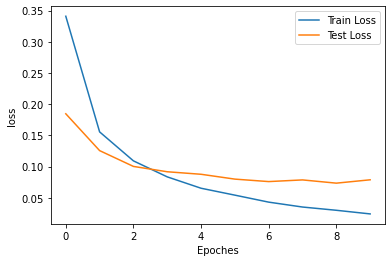

In [10]:
plt.plot(TrainLoss, label='Train Loss')
plt.plot(TestLoss, label='Test Loss')
plt.xlabel('Epoches')
plt.ylabel('loss')
plt.legend()
plt.show()

In [26]:
def plot_confusion_matrix(P, Y, split, cmap=None, normalize=False):
    cm = confusion_matrix(Y, P)

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix for MNIST classification on {} Split'.format(split))
    plt.colorbar()

    class_names = list(set(Y))

    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=0)
        plt.yticks(tick_marks, class_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig('cm_{}.png'.format(split))

Train Accuracy : 0.9945166666666667 , Test Accuracy : 0.976


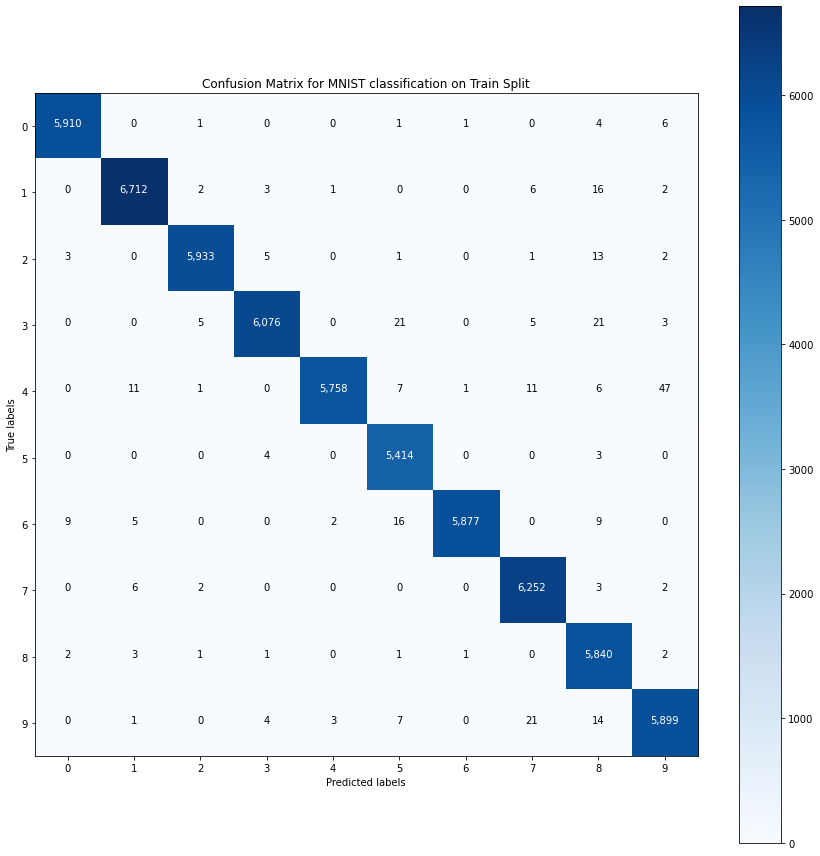

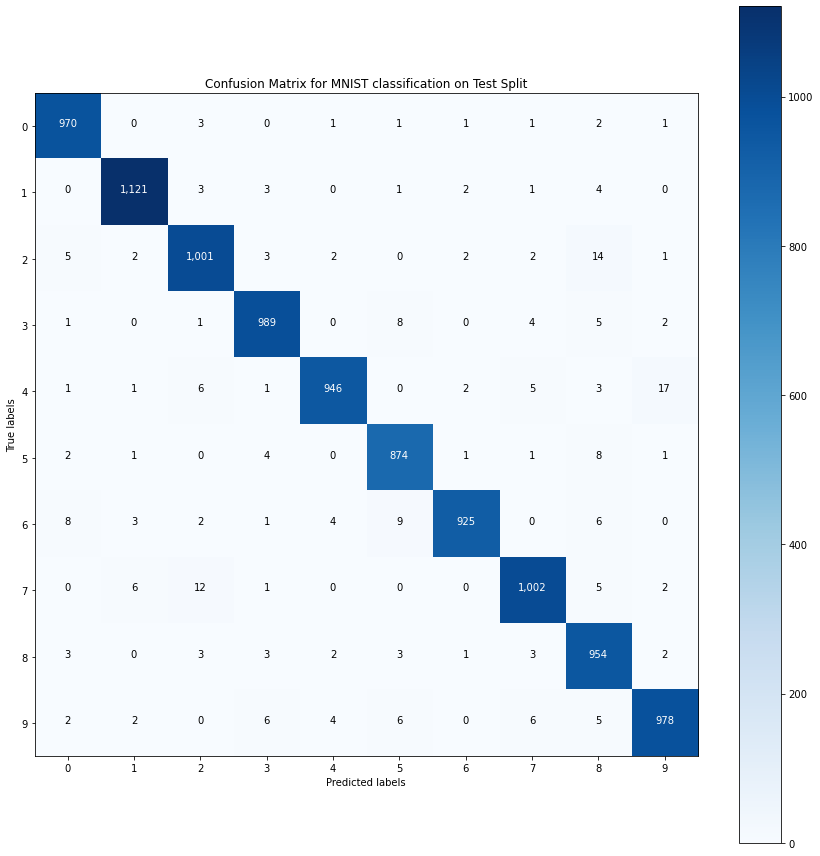

In [27]:
# Model Accuracy

with torch.no_grad():
    n_correct = 0
    n_total = 0
    Ylabels = []
    Plabels = []
    for x, y in train_loader:
        x = x.to(device) 
        y = y.to(device).numpy()
        
        Ylabels.extend(y.tolist())
        
        x = x.view(-1, W * H)

        prediction = model(x)
        prediction = torch.argmax(prediction, 1)
        
        Plabels.extend(prediction.numpy().tolist())
        
        n_correct += sum(prediction.numpy() == y)
        n_total += len(y)
        
    train_acc = n_correct / n_total
    plot_confusion_matrix(Plabels, Ylabels, 'Train')
    
    n_correct = 0
    n_total = 0
    Ylabels = []
    Plabels = []
    for x, y in test_loader:
        x = x.to(device) 
        y = y.to(device).numpy()

        Ylabels.extend(y.tolist())
        
        x = x.view(-1, W * H)

        prediction = model(x)
        prediction = torch.argmax(prediction, 1)
        
        Plabels.extend(prediction.numpy().tolist())
        
        n_correct += sum(prediction.numpy() == y)
        n_total += len(y)
        
    test_acc = n_correct / n_total
    plot_confusion_matrix(Plabels, Ylabels, 'Test')
    
print("Train Accuracy : {} , Test Accuracy : {}".format(train_acc, test_acc))